# Get imputed matrix and plotting

In [56]:
#here::i_am("01_create_arrow.R")
source(here::here("settings.R"))
source(here::here("atac/archR/load_archR_project.R"))
options(repr.plot.width=15, repr.plot.height=5)

Setting default genome to Mm10.

Setting default number of Parallel threads to 1.

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\__

In [113]:
addArchRThreads(16)
options(repr.plot.width=12, repr.plot.height=6)


Setting default number of Parallel threads to 16.



In [80]:
## get metadata & filter cells that pass QC
# you probably already did this before
io$archR.metadata = sprintf('%s/results/atac/archR/qc/sample_metadata_after_qc.txt.gz', io$basedir)
sample_metadata <- fread(io$archR.metadata) %>%
  .[pass_atacQC==TRUE & doublet_call==FALSE]

# subset project to cells that pass QC
ArchRProject <- ArchRProject[sample_metadata$cell,]

In [61]:
### Get gene score matrix 

# Below is the code to get a matrix from the project
# the GeneScoreMatrix_distal is the standard archR calculation for GeneScores, the TSS one only looks at TSS accessibility
# I recommend using the distal one
# (A similar thing can be done for motifs)
genescores = getMatrixFromProject(
  ArchRProj = ArchRProject,
  useMatrix = 'GeneScoreMatrix_distal')

# The one for TSS is already stored here:
#genescores = readRDS(sprintf('%s/processed/atac/archR/Matrices/GeneScoreMatrix_TSS_summarized_experiment.rds', io$basedir))

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-158b9315a3cc0-Date-2022-12-06_Time-10-13-29.log
If there is an issue, please report to github with logFile!

2022-12-06 10:14:10 : Organizing colData, 0.683 mins elapsed.

2022-12-06 10:14:10 : Organizing rowData, 0.693 mins elapsed.

2022-12-06 10:14:10 : Organizing rowRanges, 0.693 mins elapsed.

2022-12-06 10:14:10 : Organizing Assays (1 of 1), 0.693 mins elapsed.

2022-12-06 10:15:02 : Constructing SummarizedExperiment, 1.559 mins elapsed.

2022-12-06 10:15:03 : Finished Matrix Creation, 1.575 mins elapsed.



In [65]:
genescores

class: SummarizedExperiment 
dim: 24333 33177 
metadata(0):
assays(1): GeneScoreMatrix_distal
rownames: NULL
rowData names(6): seqnames start ... name idx
colnames(33177): 2_Eo_DEG_G9_day3_5_VC#CTACGAAGTGAGCACT-1
  2_Eo_DEG_G9_day3_5_VC#TGGACAAAGCTCAATA-1 ...
  2_Eo_DEG_G9_day5_VC#GACCTTTGTTGCGGAT-1
  2_Eo_DEG_G9_day5_VC#CGCTCCATCATCCTGC-1
colData names(38): BlacklistRatio nDiFrags ... ReadsInPeaks FRIP

In [66]:
# Extract the actual matrix
genescores.mtx = genescores@assays@data$GeneScoreMatrix_distal
rownames(genescores.mtx) = rowData(genescores)$name

In [67]:
genescores.mtx[1:10, 1:10]

   [[ suppressing 10 column names ‘2_Eo_DEG_G9_day3_5_VC#CTACGAAGTGAGCACT-1’, ‘2_Eo_DEG_G9_day3_5_VC#TGGACAAAGCTCAATA-1’, ‘2_Eo_DEG_G9_day3_5_VC#GTGAGCGAGCTCCTAC-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                                                   
Xkr4    0.628 0.813 0.439 0.572 0.599 0.733 0.524 0.834 0.497 0.392
Rp1     0.166 0.313 0.314 0.203 0.183 0.203 0.184 0.208 0.413 0.014
Sox17   0.627 0.436 1.275 1.218 1.313 0.464 0.537 1.027 0.597 0.484
Mrpl15  0.183 0.743 0.210 0.338 0.707 0.321 0.061 0.124 0.299 0.236
Lypla1  0.109 0.183 0.155 0.502 0.065 0.265 0.288 0.365 0.207 0.183
Tcea1   0.289 0.314 0.262 0.455 0.421 0.427 0.289 0.387 0.236 0.266
Rgs20   0.506 0.704 0.372 0.406 0.653 0.764 0.301 0.138 0.491 0.310
Atp6v1h 0.286 0.262 0.327 0.510 0.055 0.437 0.290 0.214 0.221 0.292
Oprk1   0.301 0.285 0.142 0.151 0.325 0.327 0.237 0.217 0.158 0.070
Npbwr1  0.426 0.713 0.369 0.234 0.149 0.710 0.458 0.382 0.308 0.153

In [68]:
### Impute values
# First make sure imputation weights are added to the ArchRProject, appearantly I haven't saved these before
# I couldn't get this to work because I can't get the reduced dimensions back in the ArchRProject :/ 
# Just use the ones you calculated for now
#ArchRProject = addImputeWeights(ArchRProject, reducedDims='PeakMatrix') 

# Impute matrix
genescores.mtx.imputed = suppressMessages(imputeMatrix(mat = as.matrix(genescores.mtx), 
                                 imputeWeights = getImputeWeights(ArchRProject)))

ERROR: Error in .validInput(input = imputeWeights, name = "imputeWeights", valid = c("list")): Input value for 'imputeWeights' is not a list, (imputeWeights = NULL) please supply valid input!


In [87]:
### Get UMAP
# Get it from the project if you have it stored in there
# UMAP = getReducedDims(
#   ArchRProj = ArchRProject,
#   reducedDims = "UMAP")

# I'll get the one I already have exported 
UMAP = fread(sprintf('%s/results/atac/archR/dimensionality_reduction/cells/PeakMatrix/remove_ExE_cells_FALSE/batch_correction_None/umap_nfeatures25000_dims25_nneighbour25_mindist0.5.txt.gz', io$basedir))

sample_metadata = merge(sample_metadata, UMAP, by='cell') %>%
    .[match(colnames(genescores.mtx), cell)] # put in the right order

In [88]:
summary(sample_metadata$cell == colnames(genescores.mtx))

   Mode    TRUE 
logical   33177 

In [104]:
# Load RNA expression
source(sprintf('%s/code/utils.R', io$basedir))
sce <- load_SingleCellExperiment(io$rna.sce, cells=sample_metadata$cell, normalise = TRUE)

In [106]:
logcounts.mtx = logcounts(sce)

In [117]:
summary(sample_metadata$cell == colnames(logcounts.mtx))

   Mode    TRUE 
logical   33177 

In [127]:
plot = function(gene, order=TRUE){
    to.plot = sample_metadata[,c('umap1', 'umap2')] %>%
        .[,GeneActivity := as.vector(genescores.mtx[gene,])] %>%
        .[,GeneActivity_capped := ifelse(GeneActivity>quantile(GeneActivity, .99), quantile(GeneActivity, .99), GeneActivity)] # Cap GeneActivity by 99 quantile


    if(order==TRUE){ # highest on top, this makes a massive difference and could make it look like accessibility is higher in areas where it is not
        to.plot = to.plot[order(GeneActivity)]
    }
    
    # plot
    p1 = ggplot(to.plot, aes(umap1, umap2, col = GeneActivity_capped)) + 
            geom_point(size=0.5, alpha=0.5) +
            scale_color_gradient(low='gray80', high='Darkblue', name='GeneActivity') + 
            ggtitle(gene, 
                    'ATAC') + 
            theme_void() + 
            theme(text=element_text(size=15))
    
    to.plot = sample_metadata[,c('umap1', 'umap2')] %>%
        .[,GeneExpr := as.vector(logcounts.mtx[gene,])]
    
    if(order==TRUE){
        to.plot = to.plot[order(GeneExpr)]
    }
    
    p2 = ggplot(to.plot, aes(umap1, umap2, col = GeneExpr)) + 
        geom_point(size=0.5, alpha=0.5) +
        scale_color_gradient(low='gray80', high='red', name='logCounts') + 
        ggtitle(gene,
               'RNA') + 
        theme_void() + 
        theme(text=element_text(size=15))
    
    return(ggarrange(p1, p2))
    
}

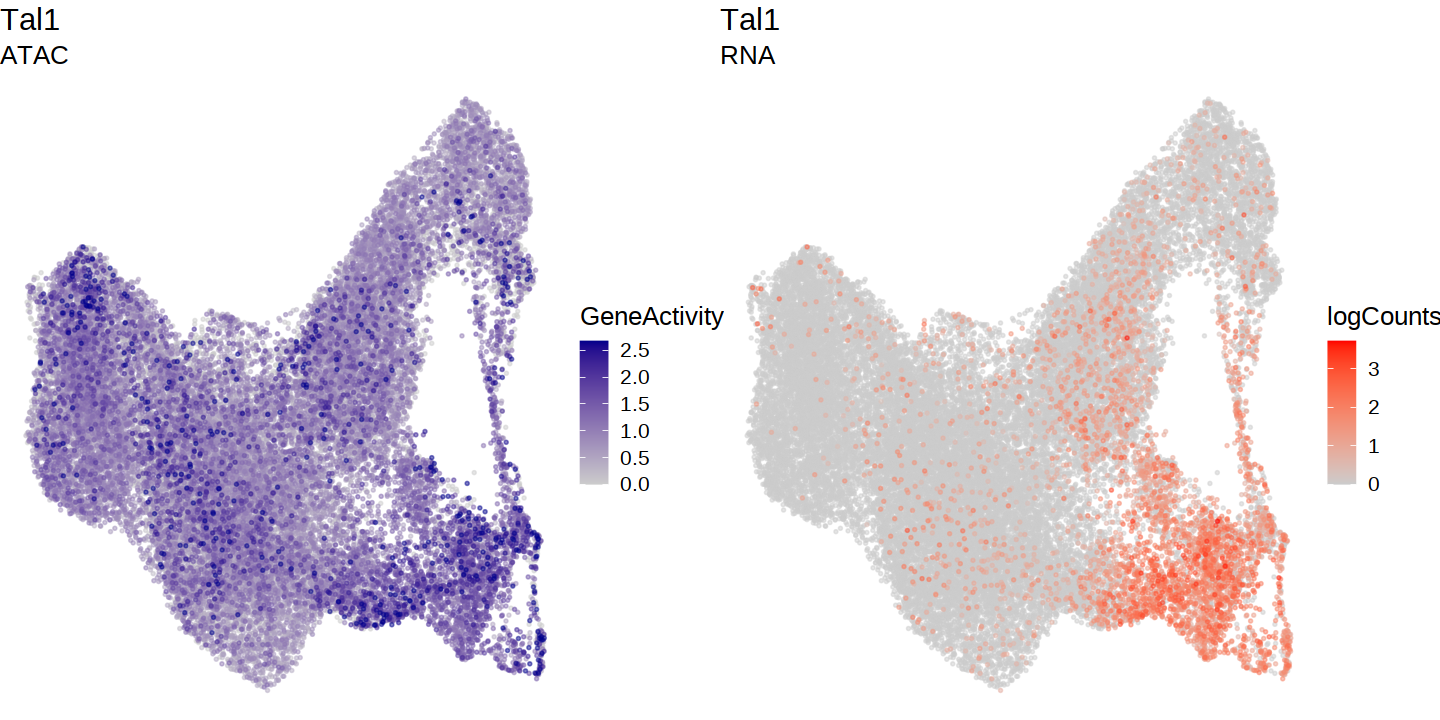

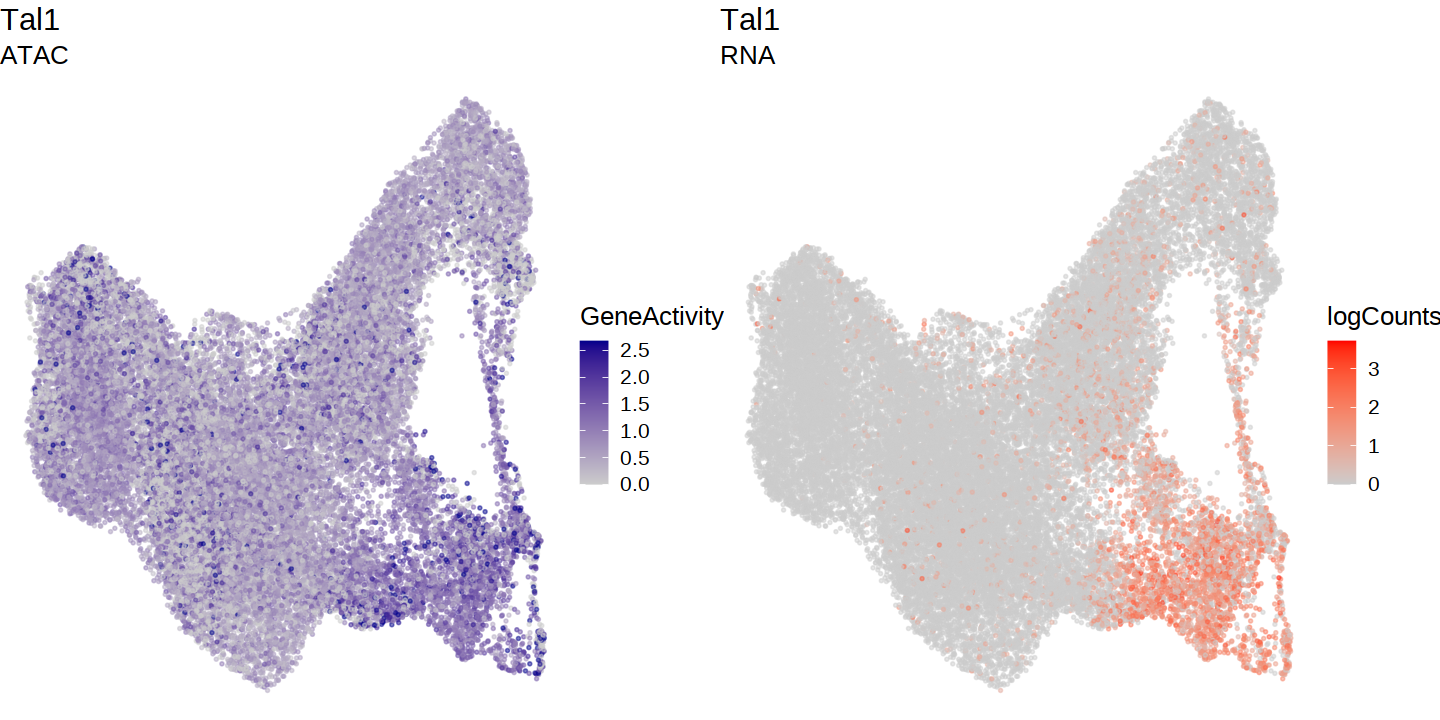

In [128]:
plot('Tal1')
plot('Tal1', order=F)

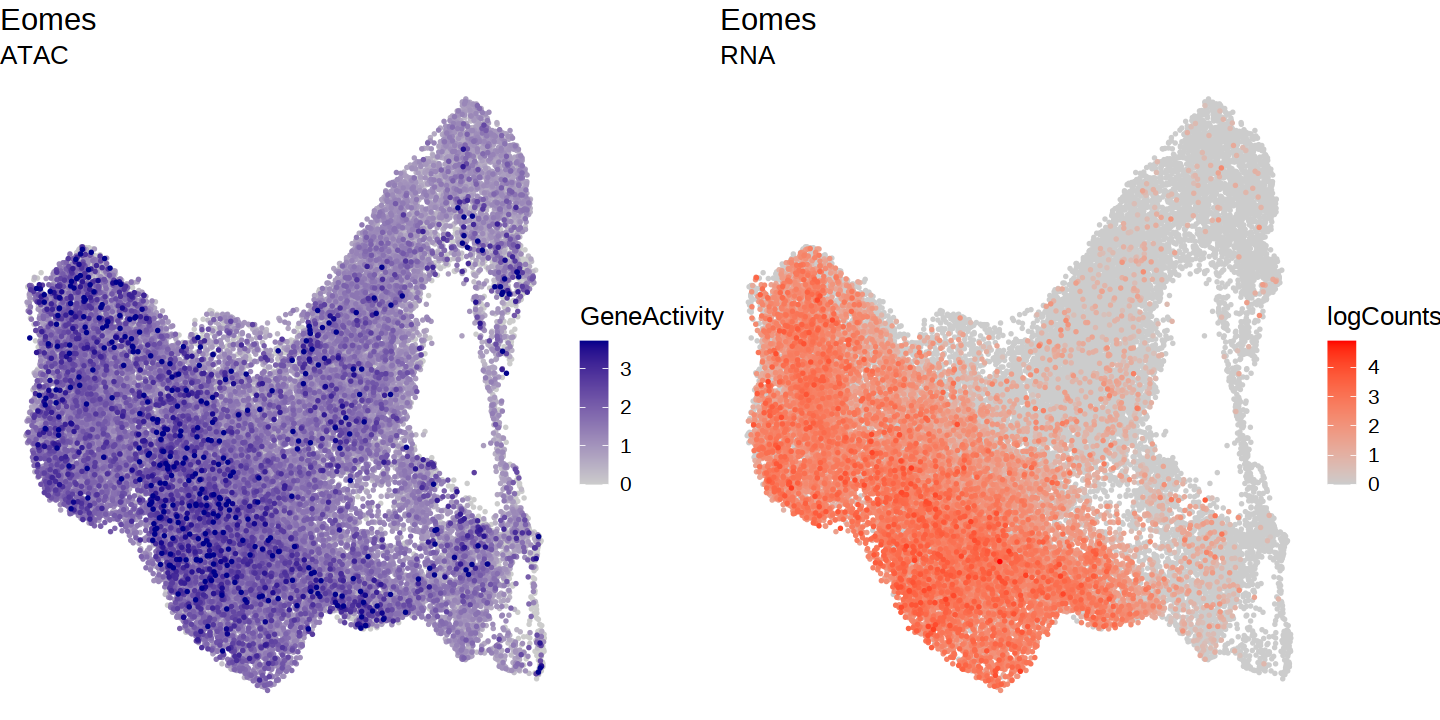

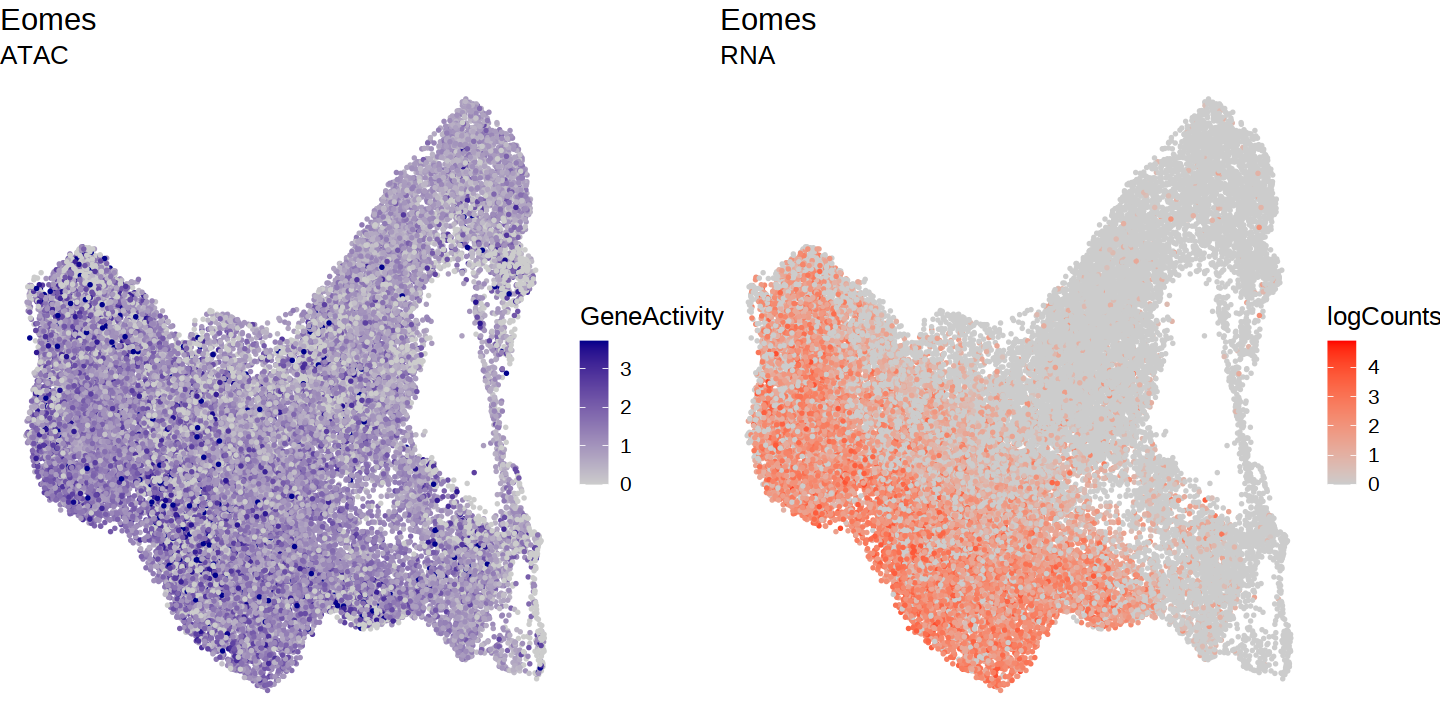

In [126]:
plot('Eomes')
plot('Eomes', order=F)